### Loading libraries

In [6]:
# basic packages for data processing
import os       # to create directories and remove files
import csv      # to remove extra columns in CSE-CIC-IDS2018 dataset
import pandas as pd
import numpy as np 
import random # import random package to specify the random seed

# modules for machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from skelm import ELMClassifier

# modules to interpret the training result
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# set the random seed to ensure the result is reproducible
random.seed(10)
np.random.seed(10)

### Loading Dataset

In [7]:
cse_cic_ids2018 = pd.read_csv(f'D:/NCI/Practicum2/dataset/CSE-CIC-IDS2018/Processed Traffic Data for ML Algorithms/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv', nrows=10)
cse_cic_ids2018_typical_columns = pd.Series(cse_cic_ids2018.columns, dtype='str')
print(cse_cic_ids2018.shape)

(10, 80)


### Load the problematic file

In [8]:
cse_cic_ids2018_20022018 = pd.read_csv('D:/NCI/Practicum2/dataset/CSE-CIC-IDS2018/Processed Traffic Data for ML Algorithms/Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv', nrows=10)
cse_cic_ids2018_20022018_columns = pd.Series(cse_cic_ids2018_20022018.columns, dtype='str')

cse_cic_ids2018_20022018.shape

(10, 84)

Check for columns that only exist in the problematic file.

In [9]:
cse_cic_ids2018_20022018_columns[~cse_cic_ids2018_20022018_columns.isin(cse_cic_ids2018_typical_columns)]

0     Flow ID
1      Src IP
2    Src Port
3      Dst IP
dtype: object

In [10]:
#drop the first four columns of each row and save it to a new csv file. At the same time, let us fix the typo "Thuesday"
with open('D:/NCI/Practicum2/dataset/CSE-CIC-IDS2018/Processed Traffic Data for ML Algorithms/Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv', 'r') as source, \
    open('D:/NCI/Practicum2/dataset/CSE-CIC-IDS2018/Processed Traffic Data for ML Algorithms/Tuesday-20-02-2018_TrafficForML_CICFlowMeter_dropped_first_four_columns.csv', 'w') as result:

    original_dataset = csv.reader(source)
    writer = csv.writer(result)

    for row in original_dataset:
        # exclude the first 4 columns when writing the file
        writer.writerow((row[4:]))

Load the processed file to ensure the problem has been addressed

In [11]:
cse_cic_ids2018_20022018 = pd.read_csv('D:/NCI/Practicum2/dataset/CSE-CIC-IDS2018/Processed Traffic Data for ML Algorithms/Tuesday-20-02-2018_TrafficForML_CICFlowMeter_dropped_first_four_columns.csv', nrows=10)
print(cse_cic_ids2018_20022018.shape)
print(cse_cic_ids2018_20022018.columns)

(10, 80)
Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg

Combine the files of the dataset

In [12]:
dataset = 'CSE-CIC-IDS2018'
dataset_csv_files = ('Friday-02-03-2018_TrafficForML_CICFlowMeter',
                    'Friday-16-02-2018_TrafficForML_CICFlowMeter',
                    'Friday-23-02-2018_TrafficForML_CICFlowMeter',
                    'Tuesday-20-02-2018_TrafficForML_CICFlowMeter_dropped_first_four_columns',
                    'Thursday-01-03-2018_TrafficForML_CICFlowMeter',
                    'Thursday-15-02-2018_TrafficForML_CICFlowMeter',
                    'Thursday-22-02-2018_TrafficForML_CICFlowMeter',
                    'Wednesday-14-02-2018_TrafficForML_CICFlowMeter',
                    'Wednesday-21-02-2018_TrafficForML_CICFlowMeter',
                    'Wednesday-28-02-2018_TrafficForML_CICFlowMeter')

In [13]:
# Define the function to combine seperate files of a dataset
# Besides combining the files, it has two additional functionality:
# 1. Replace the replacement character (\uFFFD) with '-', which is needed for the CIC-IDS2017 dataset
# 2. Down sample the dataset. If the reduce_sample_size parameter is set to true, 
#    only 10% of the dataset will be randomly selected and saved. 
def combine_csv_files(dataset: str, file_names: tuple, reduce_sample_size: bool = False):

    # create a new directory to place the combined dataset
    os.makedirs('./dataset/dataset_combined', exist_ok=True)
    # remove the dataset if it already exist
    merged_dataset_directory = f'dataset/dataset_combined/{dataset}.csv'
    if os.path.isfile(merged_dataset_directory):
        os.remove(merged_dataset_directory)
        print(f'original file({merged_dataset_directory}) has been removed')

    for (file_index, file_name) in enumerate(file_names):
        with open(f"D:/NCI/Practicum2/dataset/{dataset}/Processed Traffic Data for ML Algorithms/{file_name}.csv", 'r') as file, open(merged_dataset_directory, 'a') as out_file:
            for (line_index, line) in enumerate(file):
                # only the header of the first file will be taken
                if 'Label' in line or 'label' in line:
                    if file_index != 0 or line_index != 0:
                        continue
                elif reduce_sample_size:
                    if random.randint(1, 10) > 1:
                        continue
                # replace the replacement character (\uFFFD) with '-' if exist     
                out_file.write(line.replace(' ï¿½ ', '-'))
                

In [14]:
combine_csv_files(dataset, dataset_csv_files, reduce_sample_size=True)

original file(dataset/dataset_combined/CSE-CIC-IDS2018.csv) has been removed


preliminary analysis

In [15]:
# load the dataset into one DataFrame
cse_cic_ids2018 = pd.read_csv('dataset/dataset_combined/CSE-CIC-IDS2018.csv')
cse_cic_ids2018.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49684,6,02/03/2018 08:47:38,281,2,1,38.0,0.0,38.0,0.0,...,20,0.0000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,Benign
1,443,6,02/03/2018 08:47:41,250,2,0,0.0,0.0,0.0,0.0,...,20,0.0000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,60860062,15,13,870.0,3306.0,535.0,0.0,...,20,130201.6667,148831.65440,434003.0,69408.0,10000000.0,16330.68406,10000000.0,9968389.0,Benign
3,443,6,02/03/2018 08:47:38,118281864,36,83,1022.0,108156.0,250.0,0.0,...,20,134521.0000,79961.04903,191062.0,77980.0,59000000.0,44452.97491,59000000.0,58900000.0,Benign
4,49745,6,02/03/2018 08:51:24,96328,2,1,38.0,0.0,38.0,0.0,...,20,0.0000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,Benign


In [16]:
print(f"Number of rows: {cse_cic_ids2018.shape[0]}")
print(f"Number of columns: {cse_cic_ids2018.shape[1]}")

Number of rows: 1622580
Number of columns: 80


In [17]:
print("Columns in the dataset:")
cse_cic_ids2018.columns

Columns in the dataset:


Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [18]:
print('Class distribution:')
cse_cic_ids2018['Label'].value_counts()

Class distribution:


Label
Benign                      1347953
DDOS attack-HOIC              68801
DDoS attacks-LOIC-HTTP        57550
DoS attacks-Hulk              46014
Bot                           28539
FTP-BruteForce                19484
SSH-Bruteforce                18485
Infilteration                 16160
DoS attacks-SlowHTTPTest      14110
DoS attacks-GoldenEye          4154
DoS attacks-Slowloris          1076
DDOS attack-LOIC-UDP            163
Brute Force -Web                 59
Brute Force -XSS                 25
SQL Injection                     7
Name: count, dtype: int64

In [19]:
print('Class distribution (normalized):')
cse_cic_ids2018['Label'].value_counts()/cse_cic_ids2018.shape[0]*100

Class distribution (normalized):


Label
Benign                      83.074671
DDOS attack-HOIC             4.240222
DDoS attacks-LOIC-HTTP       3.546820
DoS attacks-Hulk             2.835854
Bot                          1.758866
FTP-BruteForce               1.200804
SSH-Bruteforce               1.139235
Infilteration                0.995945
DoS attacks-SlowHTTPTest     0.869603
DoS attacks-GoldenEye        0.256012
DoS attacks-Slowloris        0.066314
DDOS attack-LOIC-UDP         0.010046
Brute Force -Web             0.003636
Brute Force -XSS             0.001541
SQL Injection                0.000431
Name: count, dtype: float64

Check for null values

In [20]:
cse_cic_ids2018_null_count = cse_cic_ids2018.isnull().sum()
cse_cic_ids2018_null_count = cse_cic_ids2018_null_count[cse_cic_ids2018_null_count > 0]
print(f"Rows contain null value: \n{cse_cic_ids2018_null_count}\n")

cse_cic_ids2018_null_count = cse_cic_ids2018_null_count / cse_cic_ids2018.shape[0] * 100
print(f"Rows contain null value (percentage): \n{cse_cic_ids2018_null_count}\n")

Rows contain null value: 
Flow Byts/s    5975
dtype: int64

Rows contain null value (percentage): 
Flow Byts/s    0.368241
dtype: float64



Check for infinity value

In [21]:
inf_count = np.isinf(cse_cic_ids2018.iloc[:, 3:-1]).any(axis=1).sum()
print(f'Number of rows includes infinity value: {inf_count}; {inf_count/cse_cic_ids2018.shape[0]*100:.2f}% of rows')

Number of rows includes infinity value: 9539; 0.59% of rows


Check for columns that contain string values

In [22]:
cse_cic_ids2018.dtypes[(cse_cic_ids2018.dtypes != 'int64') & (cse_cic_ids2018.dtypes != 'float64')]

Timestamp    object
Label        object
dtype: object

In [23]:
cse_cic_ids2018['Label'].unique()

array(['Benign', 'Bot', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk',
       'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection',
       'DDoS attacks-LOIC-HTTP', 'Infilteration', 'DoS attacks-GoldenEye',
       'DoS attacks-Slowloris', 'FTP-BruteForce', 'SSH-Bruteforce',
       'DDOS attack-LOIC-UDP', 'DDOS attack-HOIC'], dtype=object)

In [24]:
cse_cic_ids2018['Timestamp']

0          02/03/2018 08:47:38
1          02/03/2018 08:47:41
2          02/03/2018 08:47:40
3          02/03/2018 08:47:38
4          02/03/2018 08:51:24
                  ...         
1622575    28/02/2018 01:48:05
1622576    28/02/2018 02:23:17
1622577    28/02/2018 04:05:10
1622578    28/02/2018 11:12:19
1622579    28/02/2018 01:48:05
Name: Timestamp, Length: 1622580, dtype: object

Check for duplicates


In [25]:
cse_cic_ids2018.columns[cse_cic_ids2018.columns.value_counts() > 1]

Index([], dtype='object')

In [26]:
cse_cic_ids2018_duplicates = cse_cic_ids2018[cse_cic_ids2018.duplicated()]
print(f"number of duplicated rows: {cse_cic_ids2018_duplicates.shape[0]}")
print(f"{cse_cic_ids2018_duplicates.shape[0]/cse_cic_ids2018.shape[0]*100:.2f}% of rows are duplicates")

number of duplicated rows: 17140
1.06% of rows are duplicates


### Dataset cleaning

In [27]:
# remove rows with null and infinity value
with pd.option_context('mode.use_inf_as_na', True):
    cse_cic_ids2018 = cse_cic_ids2018.dropna(how='any')

cse_cic_ids2018.shape

(1613041, 80)

In [28]:
cse_cic_ids2018 = cse_cic_ids2018.drop_duplicates()
cse_cic_ids2018.shape

(1595913, 80)

### Dataset preparation
1. CSE-CIC-IDS2018 dataset will be downsampled and all attack samples will be labeled as 'malicious'

In [29]:
# get the number of sample for each class
sample_count_per_class = cse_cic_ids2018['Label'].value_counts()
sample_count_per_class

Label
Benign                      1338122
DDOS attack-HOIC              68628
DDoS attacks-LOIC-HTTP        57550
DoS attacks-Hulk              45691
Bot                           28501
SSH-Bruteforce                16312
Infilteration                 16034
FTP-BruteForce                12368
DoS attacks-SlowHTTPTest       7251
DoS attacks-GoldenEye          4153
DoS attacks-Slowloris          1049
DDOS attack-LOIC-UDP            163
Brute Force -Web                 59
Brute Force -XSS                 25
SQL Injection                     7
Name: count, dtype: int64

In [30]:
def downsample_dataset(dataset: pd.DataFrame, sample_count_per_class: pd.Series, max_sample: int) -> pd.DataFrame:
    dataset_downsampled = pd.DataFrame()
    for label, count in sample_count_per_class.items():

        # set the upper bound
        if count > max_sample:
            sample_size = max_sample
        else:
            sample_size = count

        sample = dataset[dataset['Label'] == label].sample(n=sample_size).reset_index(drop=True)
        dataset_downsampled = pd.concat([dataset_downsampled, sample])
    
    return dataset_downsampled

In [31]:
ids2018_attack = downsample_dataset(cse_cic_ids2018, sample_count_per_class[1:], max_sample=100000)
num_attack_sample = ids2018_attack.shape[0]
ids2018_benign = cse_cic_ids2018[cse_cic_ids2018['Label'] == 'Benign'].sample(n=num_attack_sample).reset_index(drop=True)
ids2018_downsampled = pd.concat([ids2018_attack, ids2018_benign])
del ids2018_attack
del ids2018_benign

print('Distribution of class after downsampling')
ids2018_downsampled['Label'].value_counts()

Distribution of class after downsampling


Label
Benign                      257791
DDOS attack-HOIC             68628
DDoS attacks-LOIC-HTTP       57550
DoS attacks-Hulk             45691
Bot                          28501
SSH-Bruteforce               16312
Infilteration                16034
FTP-BruteForce               12368
DoS attacks-SlowHTTPTest      7251
DoS attacks-GoldenEye         4153
DoS attacks-Slowloris         1049
DDOS attack-LOIC-UDP           163
Brute Force -Web                59
Brute Force -XSS                25
SQL Injection                    7
Name: count, dtype: int64

In [32]:
print('Class distribution (normalized):')
ids2018_downsampled['Label'].value_counts()/ids2018_downsampled.shape[0]*100

Class distribution (normalized):


Label
Benign                      50.000000
DDOS attack-HOIC            13.310783
DDoS attacks-LOIC-HTTP      11.162143
DoS attacks-Hulk             8.862024
Bot                          5.527928
SSH-Bruteforce               3.163803
Infilteration                3.109884
FTP-BruteForce               2.398842
DoS attacks-SlowHTTPTest     1.406372
DoS attacks-GoldenEye        0.805497
DoS attacks-Slowloris        0.203459
DDOS attack-LOIC-UDP         0.031615
Brute Force -Web             0.011443
Brute Force -XSS             0.004849
SQL Injection                0.001358
Name: count, dtype: float64

In [33]:
# replace the label of all attack class to 'malicious'
ids2018_downsampled.iloc[ids2018_downsampled['Label'] != 'Benign', -1] = 'malicious'
ids2018_downsampled.iloc[ids2018_downsampled['Label'] == 'Benign', -1] = 'benign'
ids2018_downsampled['Label'].value_counts()

Label
malicious    257791
benign       257791
Name: count, dtype: int64

In [34]:
# drop the additional columns
ids2018_downsampled = ids2018_downsampled.drop(['Protocol', 'Timestamp'], axis=1).copy()
ids2018_downsampled.head()

,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,1693,2,0,0.0,0.0,0.0,0.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malicious
1,80,2200,2,0,0.0,0.0,0.0,0.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malicious
2,80,2200,2,0,0.0,0.0,0.0,0.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malicious
3,80,5743,2,0,0.0,0.0,0.0,0.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malicious
4,80,8655,2,0,0.0,0.0,0.0,0.0,0.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malicious


In [35]:
# function to save the cleaned dataset
def save_cleaned_dataset(dataframe: pd.DataFrame,dataset: str, tag: str = ""):
    # create a new directory to save the cleaned dataset
    os.makedirs('./dataset/dataset_cleaned', exist_ok=True)

    if not(tag == ""):
        tag = "_" + tag

    dataframe.to_csv(f'dataset/dataset_cleaned/{dataset}{tag}.csv', index=False)

In [36]:
# Save the dataset
save_cleaned_dataset(ids2018_downsampled, 'CSE-CIC-IDS2018_cleaned')

In [37]:
# loading cleaned dataset
ids2018 = pd.read_csv('./dataset/dataset_cleaned/CSE-CIC-IDS2018_cleaned.csv')
ids2018 = ids2018.sample(frac=0.1).reset_index(drop=True)
ids2018.shape

(51558, 78)

### Feature Selection

There are two methods that will be used to perform the feature selection:
1. Random forest - The features will be ranked based on the importance score provided by the random forest classifier and the top $n$ features will be selected
2. Brute force - Train the ML models by using different number of features. The accuracy of each model with respect to the number of features will be recorded to select the most concise feature set.set.

#### Random Forest feature selection

In [38]:
ids2018_X = ids2018.drop('Label', axis=1).copy()
ids2018_y = ids2018['Label'].copy()
print("Columns in the dataset:")
ids2018.head(5)

Columns in the dataset:


,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3389,5367285,12,7,1052.0,1429.0,581.0,0.0,87.666667,169.503732,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
1,80,3699,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
2,80,30311,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malicious
3,80,9202,3,4,314.0,935.0,314.0,0.0,104.666667,181.287984,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malicious
4,443,239,3,0,77.0,0.0,46.0,0.0,25.666667,23.459184,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign


In [39]:
X_columns = ids2018_X.columns
ids2018_X = StandardScaler().fit_transform(ids2018_X)

In [40]:
%%time
rfc = RandomForestClassifier()

# fit random forest classifier on the training set
rfc.fit(ids2018_X, ids2018_y)

CPU times: total: 11.5 s
Wall time: 26.5 s


RandomForestClassifier()

Top 20 features: 
                   importance
feature                      
Dst Port                0.072
Subflow Fwd Byts        0.057
Init Fwd Win Byts       0.049
Fwd Pkt Len Max         0.048
Fwd Pkt Len Mean        0.048
Init Bwd Win Byts       0.042
Fwd Header Len          0.035
Fwd Seg Size Avg        0.035
TotLen Fwd Pkts         0.032
Flow IAT Mean           0.027
Fwd IAT Max             0.025
Fwd IAT Mean            0.024
Fwd Seg Size Min        0.023
Flow IAT Max            0.023
Flow Duration           0.021
Fwd Pkts/s              0.021
Fwd IAT Tot             0.021
Bwd Pkts/s              0.020
Fwd IAT Min             0.020
Flow Pkts/s             0.018


<Axes: xlabel='feature'>

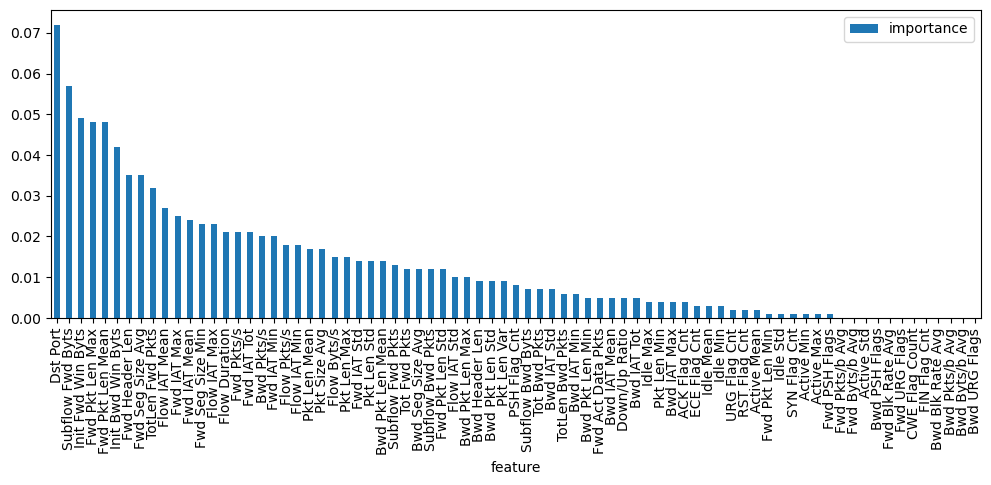

In [41]:
# extract the importance score from the random forest classifier
score = np.round(rfc.feature_importances_, 3)
importance = pd.DataFrame({'feature': X_columns, 
                            'importance': score})
importance = importance.sort_values('importance', ascending=False).set_index('feature')

print(f"Top 20 features: \n{importance[:20]}")

plt.rcParams['figure.figsize'] = (12, 4)
importance.plot.bar()

In [42]:
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):
    
    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag
    
    directory = 'dataset/features_selected'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"
    
    # create directory to save the file
    os.makedirs(directory, exist_ok=True)
    
    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"The features have been saved in {directory}/{file_name}.csv")

In [43]:
features = pd.Series(importance.index[:20], dtype='str')
save_feature(features=features, 
            dataset_name='CIC-IDS2018', 
            algorithm='RandomForestClassifier')

The features have been saved in dataset/features_selected/CIC-IDS2018_RandomForestClassifier_20.csv


#### Brute force feature reduction

In [44]:
columns = features.tolist() +  ['Label']

ids2018 = ids2018[columns]
ids2018.shape

(51558, 21)

In [45]:
ids2018_X = ids2018.drop('Label', axis=1).copy()
ids2018_y = ids2018['Label'].copy()

ids2018_train_X, ids2018_test_X, ids2018_train_y, ids2018_test_y = train_test_split(ids2018_X, ids2018_y, test_size=0.3)

In [48]:
# define ML models without optimized hyperparameter
models = {
    'Decision Tree': tree.DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(40), max_iter=500),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(12, 12, 12), max_iter=500),
    'Extreme Learning Machine': ELMClassifier(n_neurons=(12, 12, 12), ufunc='tanh', batch_size=1000),
}

In [49]:
feature_set = []
scalar = StandardScaler()
scores = []

for feature in features:
    feature_set.append(feature)
    print(f"Added feature {len(feature_set)} ({feature})...")\
    
    test_X = ids2018_test_X[feature_set]
    train_X = ids2018_train_X[feature_set]

    # scale the dataset
    train_X_scaled = scalar.fit(train_X)
    train_X_scaled = scalar.transform(train_X)
    test_X_scaled = scalar.transform(test_X)

    score_temp = [len(feature_set)]

    for model in models:
        clf = models[model]
        clf.fit(train_X_scaled, ids2018_train_y)

        prediction = clf.predict(test_X_scaled)
        accuracy = metrics.accuracy_score(ids2018_test_y, prediction)

        score_temp.append(accuracy)

    scores.append(score_temp)


scores = np.array(scores)

Added feature 1 (Dst Port)...
Added feature 2 (Subflow Fwd Byts)...
Added feature 3 (Init Fwd Win Byts)...
Added feature 4 (Fwd Pkt Len Max)...
Added feature 5 (Fwd Pkt Len Mean)...
Added feature 6 (Init Bwd Win Byts)...
Added feature 7 (Fwd Header Len)...
Added feature 8 (Fwd Seg Size Avg)...
Added feature 9 (TotLen Fwd Pkts)...
Added feature 10 (Flow IAT Mean)...
Added feature 11 (Fwd IAT Max)...
Added feature 12 (Fwd IAT Mean)...
Added feature 13 (Fwd Seg Size Min)...
Added feature 14 (Flow IAT Max)...
Added feature 15 (Flow Duration)...
Added feature 16 (Fwd Pkts/s)...
Added feature 17 (Fwd IAT Tot)...
Added feature 18 (Bwd Pkts/s)...
Added feature 19 (Fwd IAT Min)...
Added feature 20 (Flow Pkts/s)...


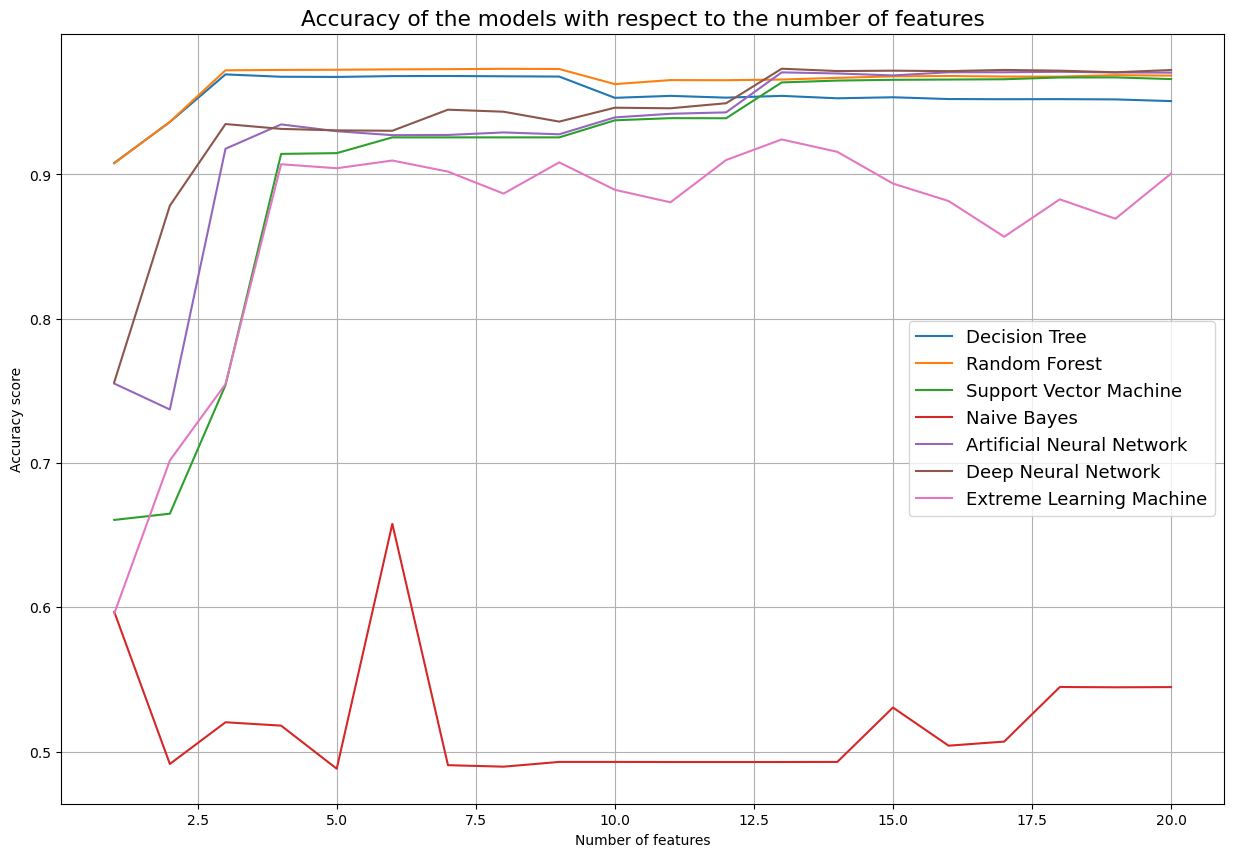

In [50]:
plt.figure(figsize=(15, 10))
for index, model in enumerate(models):
    plt.plot(scores.T[0], scores.T[index + 1], label=model)

plt.rcParams.update({'font.size': 13})
plt.title('Accuracy of the models with respect to the number of features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy score')
plt.legend()
plt.grid()
plt.show()

# Optimising models' hyperparameter

In [51]:
# Loading the feature list
features = pd.read_csv('dataset/features_selected/CIC-IDS2018_RandomForestClassifier_20.csv').squeeze()
features = features[:11]

In [52]:
columns = features.tolist() +  ['Label']

# Loading the cleaned dataset
cic_ids2018 = pd.read_csv('./dataset/dataset_cleaned/CSE-CIC-IDS2018_cleaned.csv', usecols=columns)
cic_ids2018.shape

(515582, 12)

### Processing before training

In [53]:
cic_ids2018 = cic_ids2018.sample(frac=0.1).reset_index(drop=True)

print('Class distribution: ')
cic_ids2018['Label'].value_counts()

Class distribution: 


Label
benign       25893
malicious    25665
Name: count, dtype: int64

### Split dataset 
Splitting dataset into two subsets - 70% for training and 30% for testing.

In [54]:
ids2018_X = cic_ids2018.drop('Label', axis=1).copy()
ids2018_y = cic_ids2018['Label'].copy()

ids2018_train_X, ids2018_test_X, ids2018_train_y, ids2018_test_y = train_test_split(ids2018_X, ids2018_y, test_size=0.3)

### Data Scaling

In [55]:
scalar = StandardScaler()

ids2018_train_X_scaled = scalar.fit_transform(ids2018_train_X)
ids2018_test_X_scaled = scalar.transform(ids2018_test_X)

## Optimize Hyperparameter of each models

### Decision Tree

CPU times: total: 16min 35s
Wall time: 22min 38s


<Axes: xlabel='alpha'>

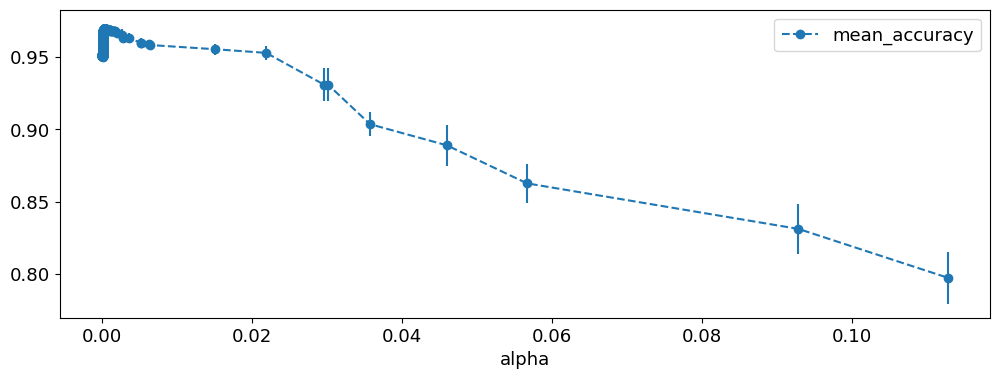

In [56]:
%%time

decision_tree = tree.DecisionTreeClassifier(criterion='entropy')
path = decision_tree.cost_complexity_pruning_path(ids2018_train_X_scaled, ids2018_train_y)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # exlude the maximum value

alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    decision_tree = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=ccp_alpha)
    scores = cross_val_score(decision_tree, ids2018_train_X_scaled, ids2018_train_y, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])


# Plot a graph of the means and standard deviations of the scores for each candidate
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', 
                    y='mean_accuracy', 
                    yerr='std', 
                    marker='o', 
                    linestyle='--')

Build the optimal tree and evaluate its accuracy

In [57]:
ideal_ccp_alpha = alpha_results.sort_values(by=['mean_accuracy'], ascending=False).iloc[0]
ideal_ccp_alpha = float(ideal_ccp_alpha['alpha'])
print(f"Optimal alpha value: {ideal_ccp_alpha}")

# build the optimum tree
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=ideal_ccp_alpha)
decision_tree.fit(ids2018_train_X_scaled, ids2018_train_y)

Optimal alpha value: 0.0003945041340130133


DecisionTreeClassifier(ccp_alpha=0.0003945041340130133, criterion='entropy')

In [58]:
# Prediction accuracy of model with optimal hyperparameters
prediction = decision_tree.predict(ids2018_test_X_scaled)
accuracy = metrics.accuracy_score(ids2018_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.97311


### Random Forest

In [59]:
%%time

parameter_space = [
    {'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [3, 0.0001, 0.0005, 0.00001], 
    'min_samples_split': [8, 0.0005, 0.0001, 0.00001], 
    'n_estimators': [100, 200, 350]
    }
]

optimal_rf = GridSearchCV(
                        RandomForestClassifier(),
                        parameter_space, 
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=0
)

optimal_rf.fit(ids2018_train_X_scaled, ids2018_train_y)
rf_optimal_params = optimal_rf.best_params_
print(f"Optimum hyperparameters: \n{rf_optimal_params}")

Optimum hyperparameters: 
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1e-05, 'min_samples_split': 0.0005, 'n_estimators': 350}
CPU times: total: 30.9 s
Wall time: 35min 20s


In [60]:
# Prediction accuracy of model with optimal hyperparameters
prediction = optimal_rf.predict(ids2018_test_X_scaled)
accuracy = metrics.accuracy_score(ids2018_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.97408


### Naive Bayes

In [62]:
%%time

parameter_space = [
    {'var_smoothing': np.logspace(0, -9, num=100)}
]

optimal_nb = GridSearchCV(
                        GaussianNB(),
                        parameter_space, 
                        cv=5,
                        n_jobs=-1,
                        verbose=0
)

optimal_nb.fit(ids2018_train_X_scaled, ids2018_train_y)
nb_optimal_params = optimal_nb.best_params_
print(f"Optimum hyperparameters: \n{nb_optimal_params}")

Optimum hyperparameters: 
{'var_smoothing': 0.1}
CPU times: total: 1.53 s
Wall time: 7.58 s


In [63]:
# Prediction accuracy of model with optimal hyperparameters
prediction = optimal_nb.predict(ids2018_test_X_scaled)
accuracy = metrics.accuracy_score(ids2018_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.77922


### Artificial Neural Network

In [64]:
%%time

parameter_space = [
    {'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.00001]}
]

ann = MLPClassifier(max_iter=500)

optimal_ann = GridSearchCV(
                        ann,
                        parameter_space, 
                        cv=5,
                        n_jobs=-1,
                        verbose=0
)

optimal_ann.fit(ids2018_train_X_scaled, ids2018_train_y)
ann_optimal_params = optimal_ann.best_params_
print(f"Optimum hyperparameters: \n{ann_optimal_params}")

Optimum hyperparameters: 
{'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
CPU times: total: 11.5 s
Wall time: 26min 4s


In [65]:
# Prediction accuracy of model with optimal hyperparameters
prediction = optimal_ann.predict(ids2018_test_X_scaled)
accuracy = metrics.accuracy_score(ids2018_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.94188


### Deep Neural Network

In [66]:
%%time

parameter_space = [
    {'hidden_layer_sizes': [(10,10, 10), (12, 12, 12), (15, 15, 15), (8, 8, 8, 8), (10, 10, 10, 10)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.00001, 0.001]}
]

dnn = MLPClassifier(max_iter=500)

optimal_dnn = GridSearchCV(
                        dnn,
                        parameter_space, 
                        cv=5,
                        n_jobs=-1,
                        verbose=0
)

optimal_dnn.fit(ids2018_train_X_scaled, ids2018_train_y)
dnn_optimal_params = optimal_dnn.best_params_
print(f"Optimum hyperparameters: \n{dnn_optimal_params}")

Optimum hyperparameters: 
{'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (12, 12, 12), 'solver': 'adam'}
CPU times: total: 14.8 s
Wall time: 17min 26s


In [67]:
# Prediction accuracy of model with optimal hyperparameters
prediction = optimal_dnn.predict(ids2018_test_X_scaled)
accuracy = metrics.accuracy_score(ids2018_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.95352


### ELM

In [85]:
%%time

# Custom wrapper for ELMClassifier to define the missing `pairwise` tag
class CustomELMClassifier(ELMClassifier):
    def _get_tags(self):
        tags = super()._get_tags()
        # Add the missing pairwise tag
        tags['pairwise'] = False
        return tags

# Define the parameter space
parameter_space = {
    'n_neurons': [1000, 2000, 5000, 7000],
    'ufunc': ['tanh', 'relu', 'sigmoid', 'linear'],
    'alpha': [1e-7, 1e-5, 1e-3, 1e-1]
}

# Initialize the CustomELMClassifier
elm = CustomELMClassifier()

optimal_elm = GridSearchCV(
                        elm,
                        parameter_space, 
                        cv=5,
                        n_jobs=-1,
                        verbose=0
)

# Perform grid search to find the best hyperparameters
optimal_elm.fit(ids2018_train_X_scaled, ids2018_train_y)

# Get the best parameters from GridSearchCV
elm_optimal_params = optimal_elm.best_params_
print(f"Optimum hyperparameters for ELM: \n{elm_optimal_params}")

Optimum hyperparameters for ELM: 
{'alpha': 1e-05, 'n_neurons': 7000, 'ufunc': 'relu'}
CPU times: total: 1min 49s
Wall time: 10min 34s


In [86]:
# Prediction accuracy of model with optimal hyperparameters
prediction = optimal_elm.predict(ids2018_test_X_scaled)
accuracy = metrics.accuracy_score(ids2018_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.96412
